In [1]:
import pyximport
pyximport.install(reload_support=True)
from umi_tools._dedup_umi import edit_distance
import umi_tools.umi_methods as umi_methods
import umi_tools.Utilities as U
import collections
import pandas as pd
import numpy as np
import pysam
import regex
import CGAT.Fastq as Fastq
import CGAT.IOTools as IOTools
import imp
import itertools
%load_ext rpy2.ipython
%matplotlib inline  

In [7]:
infile = "../run/raw/indrop_es_1.fastq.1.gz"
bc_pattern = regex.compile(
    "(?P<cell_1>.{8,12})(?P<discard_2>GAGTGATTGCTTGTGACGCCTT)(?P<cell_3>.{8})(?P<umi_1>.{6})T{3}.*")

In [33]:
subset_reads = 50000000

In [34]:
read1s = umi_methods.fastqIterate(U.openFile(infile))

# set up read extractor
ReadExtractor = umi_methods.ExtractFilterAndUpdate(
    method="regex",
    pattern=bc_pattern,
    extract_cell=True)

cell_barcode_counts_all = collections.Counter()
cell_barcode_counts = collections.Counter()

n_reads = 0
n_cell_barcodes = 0

# if using the umis method, need to keep a set of umis observed
cell_barcode_umis = collections.defaultdict(set)

for read1 in read1s:
    n_reads += 1
    barcode_values = ReadExtractor.getBarcodes(read1)
    if barcode_values is None:
        continue
    else:
        cell, umi, _, _, _, _, _ = barcode_values
        cell_barcode_umis[cell].add(umi)
        cell_barcode_counts_all[cell] += 1
        n_cell_barcodes += 1
    if n_reads % 1000000 == 0:
        print("processed %i reads, accepted %i cell barcodes" % (n_reads, n_cell_barcodes))
    if subset_reads:
        if n_cell_barcodes > subset_reads:
            break

for cell in cell_barcode_umis:
    cell_barcode_counts[cell] = len(cell_barcode_umis[cell])

print(n_reads)
print(n_cell_barcodes)

87885707
50000001


In [55]:
counts = list(cell_barcode_counts.values())
#counts = [x for x in counts if x>10]

counts_all = list(cell_barcode_counts_all.values())
#counts_all = [x for x in counts_all if x>10]

rows = []
for cell in cell_barcode_counts_all:
    if cell_barcode_counts_all[cell] > 10:
        rows.append((cell, cell_barcode_counts[cell], cell_barcode_counts_all[cell]))
        
counts_df = pd.DataFrame.from_records(rows, columns=["cell", "unique_umis", "reads"])
counts_df['duplication_rate'] = counts_df[['unique_umis', 'reads']].apply(
    axis=1, func=lambda x: 1-(x[0]/x[1]))

print(counts_df.head())

                  cell  unique_umis  reads  duplication_rate
0   ACCACTCCTCAAACCTCC            1     11          0.909091
1    ACAGATTACAGCTAATC           60     60          0.000000
2    ACTCCGCATACAGCGTG           13     28          0.535714
3  TGATGTCTTTCCGCGAAGT           14     21          0.333333
4    AACTCACAGATTGTGTC           28     28          0.000000


In [56]:
%%R -i counts_df
library(ggplot2)
library(Hmisc)
print(head(counts_df))

                 cell unique_umis reads duplication_rate
0  ACCACTCCTCAAACCTCC           1    11        0.9090909
1   ACAGATTACAGCTAATC          60    60        0.0000000
2   ACTCCGCATACAGCGTG          13    28        0.5357143
3 TGATGTCTTTCCGCGAAGT          14    21        0.3333333
4   AACTCACAGATTGTGTC          28    28        0.0000000
5    TAGTCTAGACCAGTCC           5    21        0.7619048


                 cell unique_umis reads duplication_rate         dup_bin
0  ACCACTCCTCAAACCTCC           1    11        0.9090909 [0.8127,0.9821]
1   ACAGATTACAGCTAATC          60    60        0.0000000 [0.0000,0.0912)
2   ACTCCGCATACAGCGTG          13    28        0.5357143 [0.5231,0.6671)
3 TGATGTCTTTCCGCGAAGT          14    21        0.3333333 [0.0912,0.5231)
4   AACTCACAGATTGTGTC          28    28        0.0000000 [0.0000,0.0912)
5    TAGTCTAGACCAGTCC           5    21        0.7619048 [0.7385,0.8127)


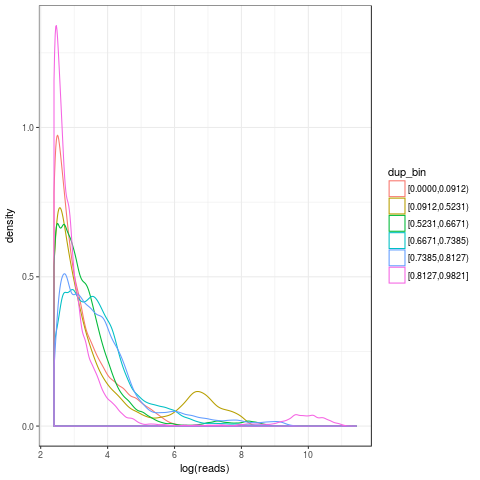

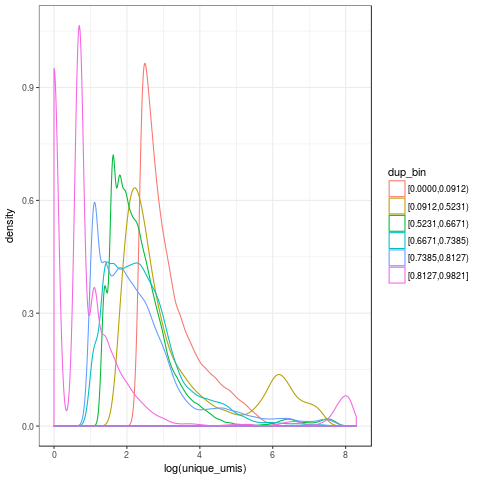

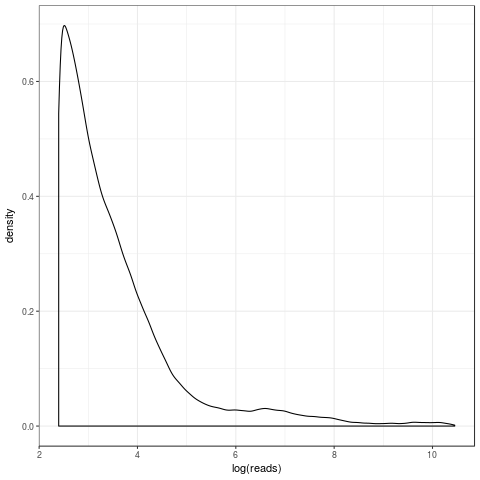

In [61]:
%%R
counts_df$dup_bin <- cut2(counts_df$duplication_rate, g=6)
print(head(counts_df))
p <- ggplot(counts_df, aes(log(reads), colour=dup_bin)) + geom_density() + theme_bw()
print(p)

p <- ggplot(counts_df, aes(log(unique_umis), colour=dup_bin)) + geom_density() + theme_bw()
print(p)





In [79]:
%%R
print(counts_df[counts_df$cell=='GACTAGACCCAAACGCCT',])

                   cell unique_umis reads duplication_rate         dup_bin
9823 GACTAGACCCAAACGCCT        3646 63876        0.9429207 [0.8127,0.9821]


                      cell unique_umis reads duplication_rate         dup_bin
106613  GAGACAGATACGCTAGTC        3960 92307        0.9570997 [0.8127,0.9821]
19628    AGCACCTCTAAGCTTCT        3847 76205        0.9495177 [0.8127,0.9821]
34732  TGATATTGCCTAACAATCC        3991 75803        0.9473504 [0.8127,0.9821]
61289     CCAACCGTCGATTGAT        3879 65090        0.9404056 [0.8127,0.9821]
8838   TGAGAAGCACTCATCGCAG        3770 64560        0.9416047 [0.8127,0.9821]
9823    GACTAGACCCAAACGCCT        3646 63876        0.9429207 [0.8127,0.9821]
       order    cum
106613     1  92307
19628      2 168512
34732      3 244315
61289      4 309405
8838       5 373965
9823       6 437841
                      cell unique_umis reads duplication_rate         dup_bin
34732  TGATATTGCCTAACAATCC        3991 75803        0.9473504 [0.8127,0.9821]
106613  GAGACAGATACGCTAGTC        3960 92307        0.9570997 [0.8127,0.9821]
61289     CCAACCGTCGATTGAT        3879 65090        0.9404056 [0.8127,0.9821]
11

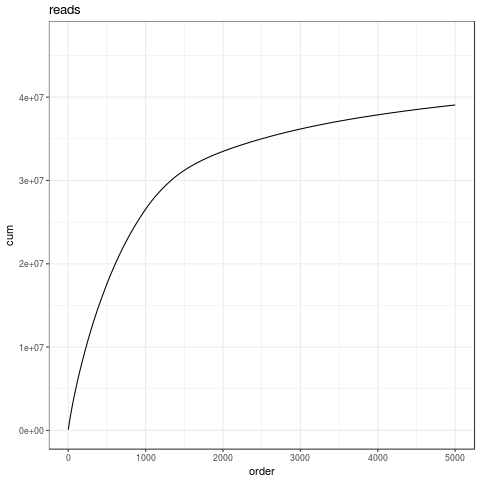

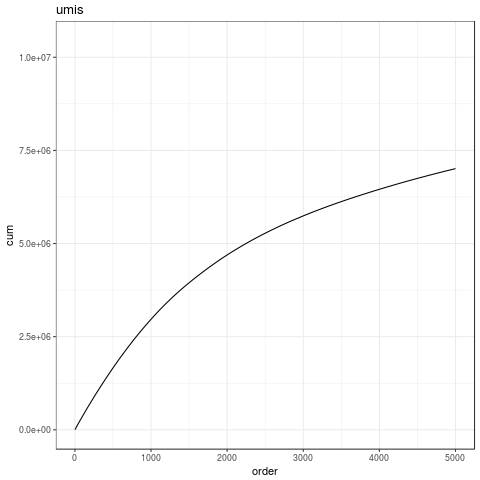

In [117]:
%%R
tmp_df <- counts_df[order(-counts_df$reads),]
tmp_df$order = seq(1, length(tmp_df[,1]))

tmp_df2 <- counts_df[order(-counts_df$unique_umis),]
tmp_df2$order = seq(1, length(tmp_df2[,1]))

tmp_df$cum <- cumsum(tmp_df$reads)
tmp_df2$cum <- cumsum(tmp_df2$unique_umis)
print(head(tmp_df))
print(head(tmp_df2))

p <- ggplot(tmp_df, aes(order, cum)) + geom_line() + theme_bw() + ggtitle("reads") + xlim(0,5000)
print(p)

p <- ggplot(tmp_df2, aes(order, cum)) + geom_line() + theme_bw() + ggtitle("umis") + xlim(0,5000)
print(p)

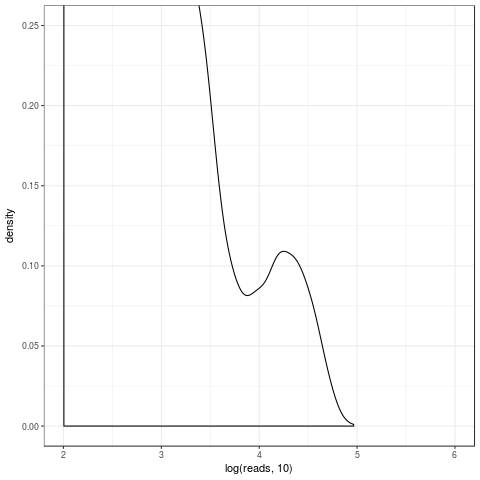

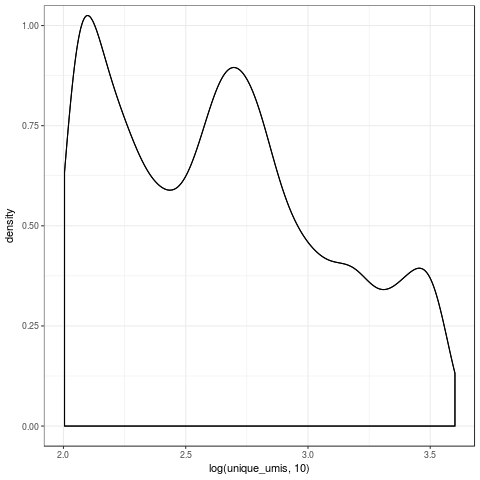

In [122]:
%%R
p <- ggplot(counts_df[counts_df$reads>100,], aes(log(reads,10))) +
geom_density() + theme_bw() + coord_cartesian(xlim = c(2,6), ylim=c(0,0.25))
print(p)

p <- ggplot(counts_df[counts_df$unique_umis>100,],
            aes(log(unique_umis,10))) + geom_density() +
geom_density() + theme_bw() +
coord_cartesian(xlim = c(2,max(log(counts_df$unique_umis,10))), ylim=c(0,1))

print(p)


In [123]:
%%R
print(sum(log(counts_df$unique_umis,10)>3.3))
print(sum(log(counts_df$reads,10)>3.8))

[1] 1212
[1] 1473


In [72]:
%%R
print(head(counts_df[order(-counts_df$reads),]))

                      cell unique_umis reads duplication_rate         dup_bin
106613  GAGACAGATACGCTAGTC        3960 92307        0.9570997 [0.8127,0.9821]
19628    AGCACCTCTAAGCTTCT        3847 76205        0.9495177 [0.8127,0.9821]
34732  TGATATTGCCTAACAATCC        3991 75803        0.9473504 [0.8127,0.9821]
61289     CCAACCGTCGATTGAT        3879 65090        0.9404056 [0.8127,0.9821]
8838   TGAGAAGCACTCATCGCAG        3770 64560        0.9416047 [0.8127,0.9821]
9823    GACTAGACCCAAACGCCT        3646 63876        0.9429207 [0.8127,0.9821]


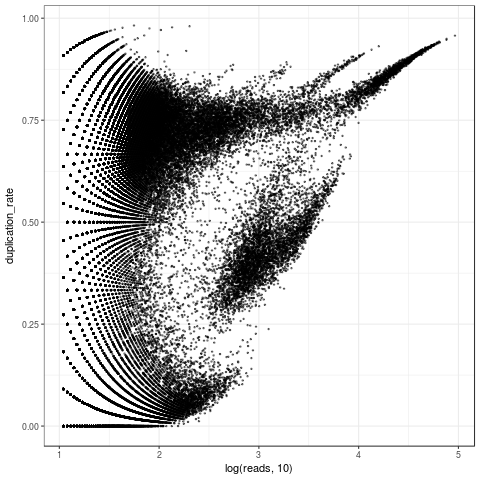

In [74]:
%%R
p <- ggplot(counts_df, aes(log(reads,10), duplication_rate)) +
geom_point(alpha=0.5, size=0.5) + theme_bw()
print(p)

[1] 6800


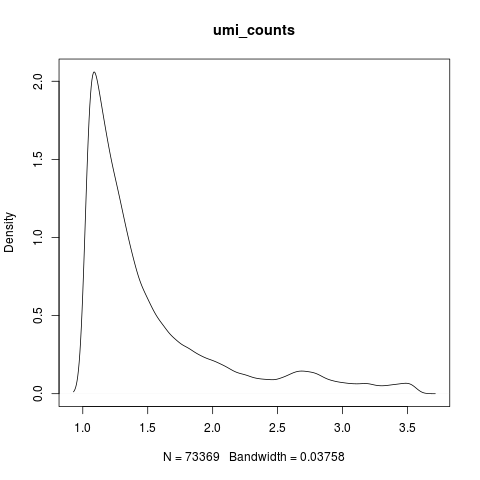

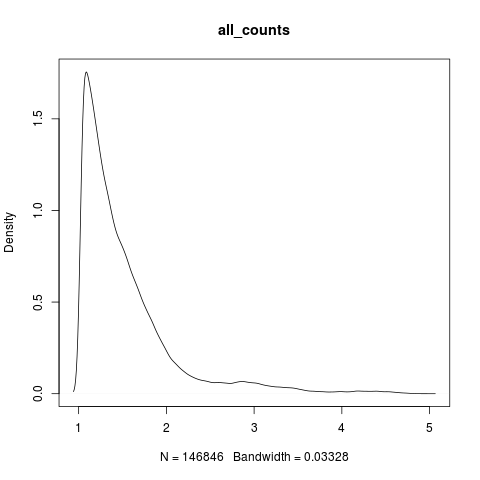

In [41]:
%%R -i counts -i counts_all

plot(density(log(counts,10)), main="umi_counts")
plot(density(log(counts_all,10)), main="all_counts")

print(sum(log(counts,10)>2.5))